In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

In [2]:
import warnings
warnings.filterwarnings("ignore")

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [3]:
df = pd.read_csv("../../General_ds_cleaned.csv")
df = df[["date", "0.25", "0.5", "0.75", "1.0", "2.0", "3.0", "5.0", "7.0", "10.0", "15.0", "20.0", "30.0"]]
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", drop=True, inplace=True)
df

,0.25,0.5,0.75,1.0,2.0,3.0,5.0,7.0,10.0,15.0,20.0,30.0
date,,,,,,,,,,,,
2003-01-04,11.68,12.31,12.76,13.08,13.63,13.72,13.63,13.53,13.45,13.38,13.35,13.32
2003-01-05,11.09,11.70,12.16,12.50,13.14,13.30,13.31,13.27,13.23,13.20,13.19,13.17
2003-01-08,10.84,11.61,12.15,12.53,13.18,13.30,13.29,13.24,13.19,13.15,13.13,13.11
2003-01-09,10.46,11.13,11.67,12.09,13.02,13.31,13.38,13.32,13.25,13.19,13.16,13.13
2003-01-10,10.10,11.08,11.79,12.28,13.14,13.31,13.27,13.19,13.11,13.04,13.00,12.97
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,13.29,12.15,11.71,11.55,11.52,11.54,11.61,11.68,11.74,11.78,11.78,11.77
2023-11-28,13.15,12.13,11.74,11.60,11.57,11.54,11.57,11.65,11.73,11.77,11.77,11.77
2023-11-29,13.30,12.05,11.58,11.43,11.49,11.53,11.59,11.65,11.71,11.74,11.75,11.75


Посмотрим на данные. Возможно лучшими моделями будут модели смешанной частоты.

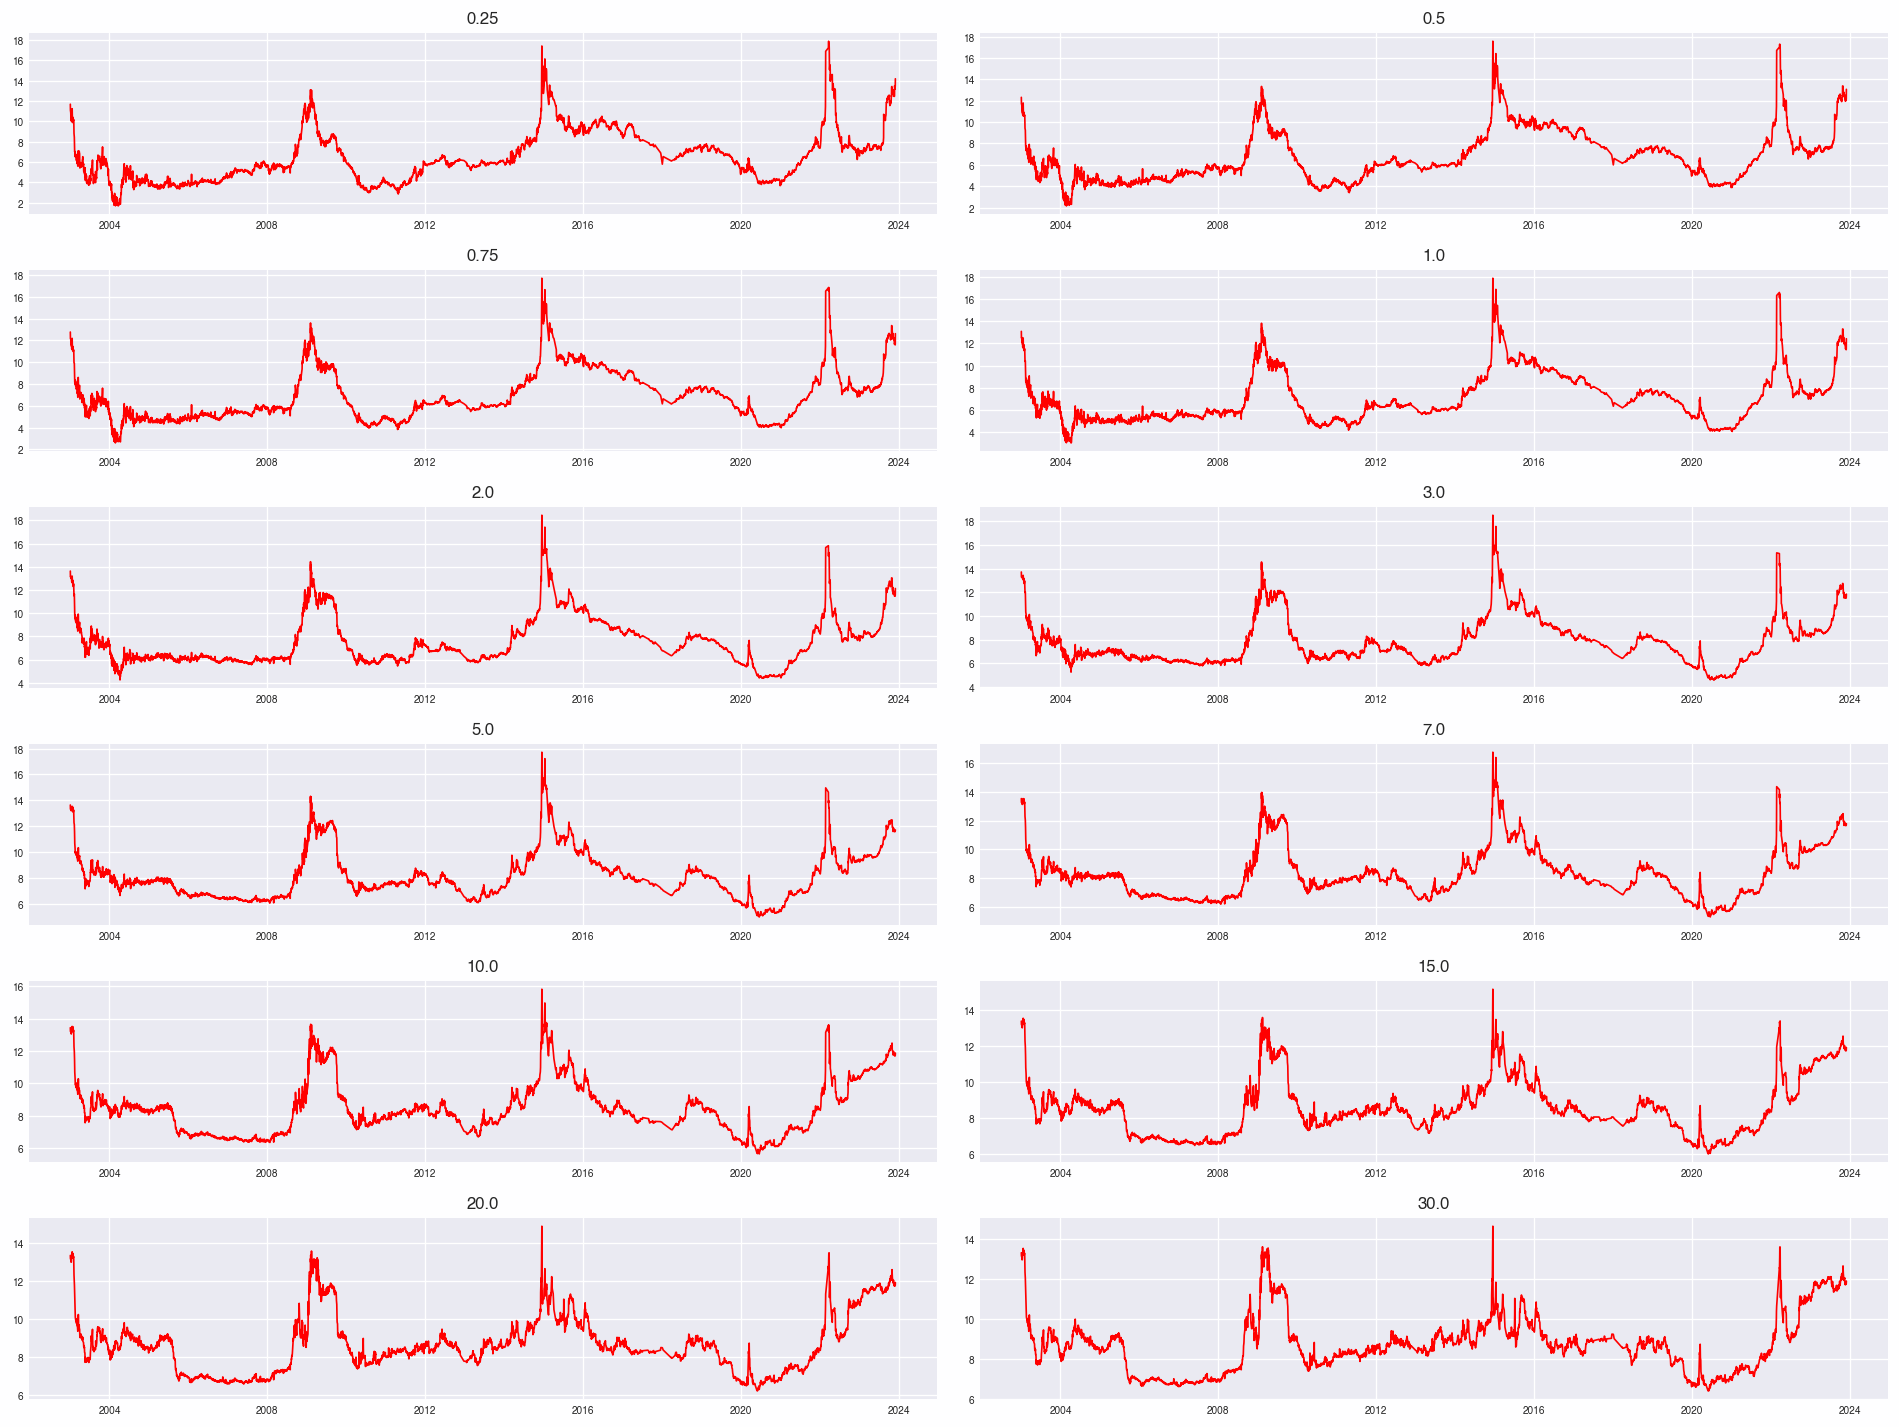

In [4]:
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(16,12))
for i, ax in enumerate(axes.flat):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df.columns[i], fontsize=10)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Посмотрим тест Granger's на причинность.

In [5]:
maxlag=10

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

matrix_granger = grangers_causation_matrix(df, variables = df.columns)

Получим таблицу с p-value причинности. Получается очень хорошо, так как все друг на друга влияют. Это как раз и нужно для VAR.

In [6]:
matrix_granger[matrix_granger < 0.05]

,0.25_x,0.5_x,0.75_x,1.0_x,2.0_x,3.0_x,5.0_x,7.0_x,10.0_x,15.0_x,20.0_x,30.0_x
0.25_y,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
0.5_y,0.0000,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
0.75_y,0.0000,0.0000,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1.0_y,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2.0_y,0.0000,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3.0_y,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,0.0000,0.0001,0.0005,0.0002
5.0_y,0.0001,0.0000,0.0000,0.0000,0.0003,0.0075,NaN,0.0023,0.0013,0.0096,0.0296,0.0015
7.0_y,0.0002,0.0001,0.0000,0.0000,0.0011,0.0103,NaN,NaN,0.0244,NaN,0.0343,0.0003
10.0_y,0.0038,0.0011,0.0004,0.0003,0.0014,0.0056,0.0163,0.0053,NaN,NaN,0.0079,0.0000
15.0_y,0.0019,0.0006,0.0004,0.0003,0.0017,0.0015,0.0003,0.0001,0.0004,NaN,0.0002,0.0000


Теперь проверим на коинтеграцию, тк это является основной предпосылкой для VAR. 

In [7]:
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df, -1, 5)
    d = {'0.90' : 0, '0.95' : 1, '0.99' : 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
0.25   ::  2226.62   > 311.1288  =>   True
0.5    ::  1581.23   > 263.2603  =>   True
0.75   ::  1179.57   > 219.4051  =>   True
1.0    ::  815.35    > 179.5199  =>   True
2.0    ::  528.48    > 143.6691  =>   True
3.0    ::  332.75    > 111.7797  =>   True
5.0    ::  203.44    > 83.9383   =>   True
7.0    ::  117.41    > 60.0627   =>   True
10.0   ::  63.51     > 40.1749   =>   True
15.0   ::  27.37     > 24.2761   =>   True
20.0   ::  9.0       > 12.3212   =>   False
30.0   ::  0.26      > 4.1296    =>   False


Теперь приступим к разбивке на test и train(с помощью дат полученных из структурных сдвигов). Для train вычитают 5 дней от структурного сдвига, а промежуток в 5 дней беру на test.
### МЕНЯТЬ ТОЛЬКО ЗДЕСЬ!!!
1. n_horizon — количество дней, на которое предсказываем 
1. epoch — промежуток, который исследуем

In [81]:
n_horizon = 5
dates_from_struct_ms = np.array([0, 657, 1384, 3943, 4502])


time_to_fit = np.maximum((dates_from_struct_ms - n_horizon), np.zeros(len(dates_from_struct_ms))).astype(int)
time_to_predict = dates_from_struct_ms

epoch = 0
df_train, df_test = df[time_to_fit[epoch]:time_to_fit[epoch + 1]], df[time_to_fit[epoch + 1]:time_to_predict[epoch + 1]]
df_train

,0.25,0.5,0.75,1.0,2.0,3.0,5.0,7.0,10.0,15.0,20.0,30.0
date,,,,,,,,,,,,
2019-10-10,6.32,6.32,6.33,6.33,6.35,6.39,6.50,6.64,6.85,7.19,7.46,7.82
2019-10-11,6.34,6.34,6.35,6.35,6.36,6.40,6.50,6.62,6.82,7.14,7.40,7.77
2019-10-14,6.27,6.31,6.34,6.35,6.37,6.39,6.47,6.59,6.78,7.11,7.38,7.74
2019-10-15,6.33,6.33,6.32,6.32,6.32,6.36,6.47,6.60,6.79,7.04,7.26,7.58
2019-10-16,6.30,6.30,6.31,6.31,6.34,6.38,6.49,6.61,6.79,7.03,7.24,7.55
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,9.69,9.68,9.67,9.66,9.61,9.57,9.53,9.48,9.39,9.25,9.14,9.00
2022-02-08,9.73,9.71,9.70,9.68,9.62,9.58,9.52,9.47,9.38,9.26,9.18,9.07
2022-02-09,9.76,9.74,9.72,9.70,9.64,9.59,9.52,9.46,9.36,9.25,9.19,9.10


Проверим на стационарность.

In [55]:
def adjust(val, length= 6): return str(val).ljust(length)

def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 

    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [56]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

/var/folders/f2/0t72_0jx48526fr5cl7zyc3h0000gn/T/ipykernel_6721/860807690.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_train.iteritems():


    Augmented Dickey-Fuller Test on "0.25" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.3291
 No. Lags Chosen       = 22
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.1628. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "0.5" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.3655
 No. Lags Chosen       = 22
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.1517. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "0.75" 
    -----------------------------------------------
 Null Hypothesis: Data has unit r

Получили, что все не стационарно. Возьмем разницу и снова проверим.

In [57]:
df_differenced = df_train.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


/var/folders/f2/0t72_0jx48526fr5cl7zyc3h0000gn/T/ipykernel_6721/623862770.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_differenced.iteritems():


    Augmented Dickey-Fuller Test on "0.25" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.9015
 No. Lags Chosen       = 21
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "0.5" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.642
 No. Lags Chosen       = 21
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "0.75" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


In [60]:
max_parametrs_for_var = 10
model = VAR(df_differenced)
for i in np.arange(1,max_parametrs_for_var):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')


/Users/ivancerepahin/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag Order = 1
AIC :  -87.32541579319142
BIC :  -86.96872121511343
FPE :  1.1886506924356213e-38
HQIC:  -87.19606707974536 

Lag Order = 2
AIC :  -87.85843474762682
BIC :  -87.17226117773275
FPE :  6.975411798563743e-39
HQIC:  -87.60960160509319 

Lag Order = 3
AIC :  -88.12322230334861
BIC :  -87.10735595063973
FPE :  5.352804460491191e-39
HQIC:  -87.75482244817496 

Lag Order = 4
AIC :  -88.29865685716315
BIC :  -86.95288370543396
FPE :  4.491641736540508e-39
HQIC:  -87.81060791659357 

Lag Order = 5
AIC :  -88.36131229379367
BIC :  -86.68541810130611
FPE :  4.2190732548298786e-39
HQIC:  -87.75353180573734 

Lag Order = 6
AIC :  -88.46000566275687
BIC :  -86.45377596191398
FPE :  3.822865620117431e-39
HQIC:  -87.73241107565643 

Lag Order = 7
AIC :  -88.50135795901707
BIC :  -86.16457805603604
FPE :  3.6684044509977735e-39
HQIC:  -87.65386663171671 

Lag Order = 8
AIC :  -88.49569915741583
BIC :  -85.82815413200034
FPE :  3.6897554734713295e-39
HQIC:  -87.52822835902907 

Lag Order = 

Получили, что лучший параметр $p = 9$.

In [61]:
p = 9
model_fitted = model.fit(p)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 04, Dec, 2023
Time:                     09:57:36
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                   -85.5306
Nobs:                     2549.00    HQIC:                  -87.4416
Log likelihood:           70735.9    FPE:                3.56915e-39
AIC:                     -88.5291    Det(Omega_mle):     2.15945e-39
--------------------------------------------------------------------
Results for equation 0.25
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.000322         0.004154            0.077           0.938
L1.0.25         0.009015         0.290674            0.031           0.975
L1.0.5         -0.746446         0.763497           -0.978           0.328
L1.0.75   

Изучим статистику Durbina для проверки корреляций между остатками. Иначе если в остатках есть корреляция, то во временном ряду есть закономерность, которую нужну объяснить.

In [62]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

0.25   : 2.0
0.5    : 2.0
0.75   : 2.01
1.0    : 2.01
2.0    : 2.01
3.0    : 2.01
5.0    : 2.01
7.0    : 2.01
10.0   : 2.01
15.0   : 2.01
20.0   : 2.01
30.0   : 2.0


Остатки выглядят очень хорошо(очень близко к 2). Теперь осталось рассмотреть предсказания. Учтем также то, что лучше всего брать промежуток для форкаста равный количестве лагов. В нашем же случае все совпало и мы точно разделили выборку.

In [63]:
var_model_forecast = model_fitted.forecast(y = df_differenced.values, steps=n_horizon)
df_forecast = pd.DataFrame(var_model_forecast, index = df_test.index, columns = df.columns + '_1d' )
df_forecast

,0.25_1d,0.5_1d,0.75_1d,1.0_1d,2.0_1d,3.0_1d,5.0_1d,7.0_1d,10.0_1d,15.0_1d,20.0_1d,30.0_1d
date,,,,,,,,,,,,
2019-10-10,0.041487,0.037073,0.035799,0.031562,0.009489,0.005778,0.004372,0.007300,0.010982,0.022207,0.025423,0.026418
2019-10-11,0.045090,0.045283,0.044921,0.045441,0.051730,0.052222,0.048456,0.040427,0.029128,0.024873,0.025949,0.029484
2019-10-14,-0.055627,-0.051338,-0.052027,-0.051589,-0.055798,-0.050634,-0.037252,-0.021505,-0.006270,0.002572,-0.000092,-0.011678
2019-10-15,-0.052514,-0.046295,-0.037544,-0.034000,-0.032033,-0.038055,-0.053068,-0.065452,-0.070403,-0.068158,-0.058256,-0.041165
2019-10-16,0.033248,0.030284,0.027268,0.024283,0.025716,0.024442,0.026274,0.028864,0.029415,0.026672,0.022768,0.024554


In [64]:
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [65]:
df_results = invert_transformation(df_train, df_forecast)
df_results

,0.25_1d,0.5_1d,0.75_1d,1.0_1d,2.0_1d,3.0_1d,5.0_1d,7.0_1d,10.0_1d,15.0_1d,...,0.75_forecast,1.0_forecast,2.0_forecast,3.0_forecast,5.0_forecast,7.0_forecast,10.0_forecast,15.0_forecast,20.0_forecast,30.0_forecast
date,,,,,,,,,,,,,,,,,,,,,
2019-10-10,0.041487,0.037073,0.035799,0.031562,0.009489,0.005778,0.004372,0.007300,0.010982,0.022207,...,6.435799,6.441562,6.489489,6.535778,6.634372,6.757300,6.970982,7.302207,7.565423,7.916418
2019-10-11,0.045090,0.045283,0.044921,0.045441,0.051730,0.052222,0.048456,0.040427,0.029128,0.024873,...,6.480720,6.487003,6.541218,6.588000,6.682828,6.797727,7.000109,7.327080,7.591372,7.945902
2019-10-14,-0.055627,-0.051338,-0.052027,-0.051589,-0.055798,-0.050634,-0.037252,-0.021505,-0.006270,0.002572,...,6.428693,6.435414,6.485420,6.537366,6.645576,6.776223,6.993839,7.329652,7.591280,7.934224
2019-10-15,-0.052514,-0.046295,-0.037544,-0.034000,-0.032033,-0.038055,-0.053068,-0.065452,-0.070403,-0.068158,...,6.391149,6.401413,6.453387,6.499311,6.592507,6.710771,6.923436,7.261495,7.533025,7.893058
2019-10-16,0.033248,0.030284,0.027268,0.024283,0.025716,0.024442,0.026274,0.028864,0.029415,0.026672,...,6.418417,6.425696,6.479102,6.523753,6.618781,6.739634,6.952852,7.288167,7.555793,7.917612


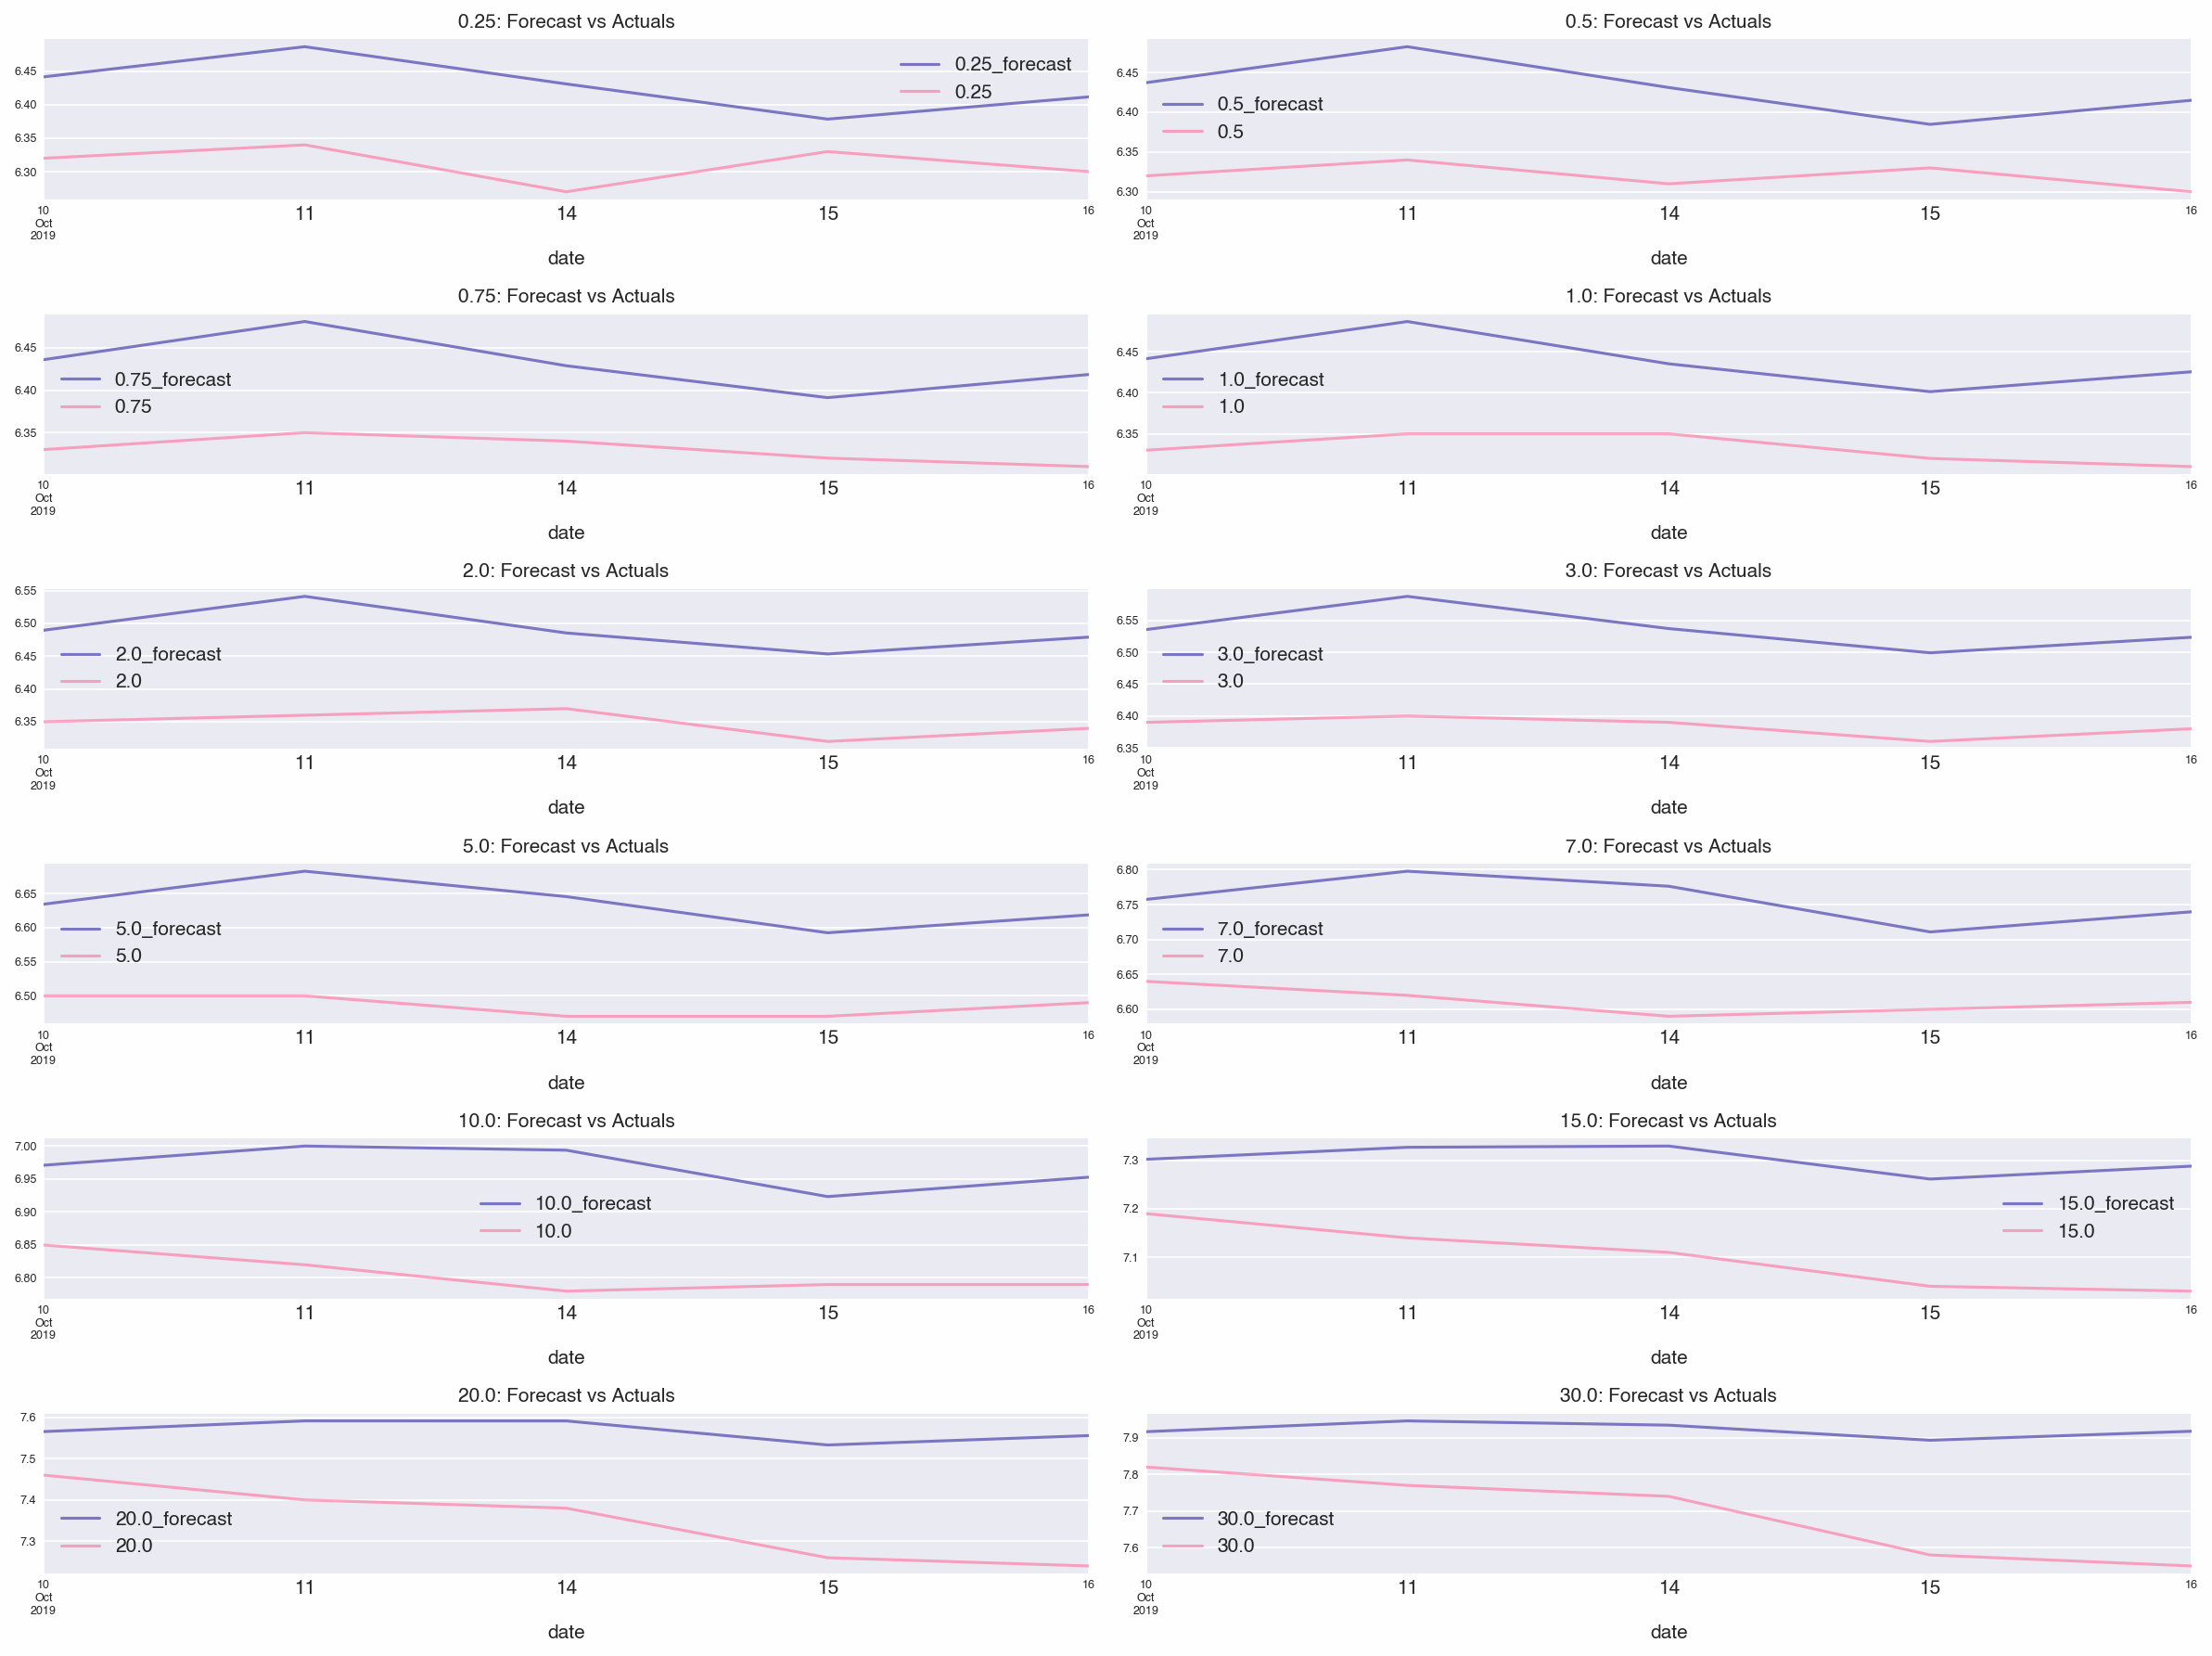

In [66]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(16, 12))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x', tight=True)
    df_test[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals", fontsize=10)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [67]:
df_results

,0.25_1d,0.5_1d,0.75_1d,1.0_1d,2.0_1d,3.0_1d,5.0_1d,7.0_1d,10.0_1d,15.0_1d,...,0.75_forecast,1.0_forecast,2.0_forecast,3.0_forecast,5.0_forecast,7.0_forecast,10.0_forecast,15.0_forecast,20.0_forecast,30.0_forecast
date,,,,,,,,,,,,,,,,,,,,,
2019-10-10,0.041487,0.037073,0.035799,0.031562,0.009489,0.005778,0.004372,0.007300,0.010982,0.022207,...,6.435799,6.441562,6.489489,6.535778,6.634372,6.757300,6.970982,7.302207,7.565423,7.916418
2019-10-11,0.045090,0.045283,0.044921,0.045441,0.051730,0.052222,0.048456,0.040427,0.029128,0.024873,...,6.480720,6.487003,6.541218,6.588000,6.682828,6.797727,7.000109,7.327080,7.591372,7.945902
2019-10-14,-0.055627,-0.051338,-0.052027,-0.051589,-0.055798,-0.050634,-0.037252,-0.021505,-0.006270,0.002572,...,6.428693,6.435414,6.485420,6.537366,6.645576,6.776223,6.993839,7.329652,7.591280,7.934224
2019-10-15,-0.052514,-0.046295,-0.037544,-0.034000,-0.032033,-0.038055,-0.053068,-0.065452,-0.070403,-0.068158,...,6.391149,6.401413,6.453387,6.499311,6.592507,6.710771,6.923436,7.261495,7.533025,7.893058
2019-10-16,0.033248,0.030284,0.027268,0.024283,0.025716,0.024442,0.026274,0.028864,0.029415,0.026672,...,6.418417,6.425696,6.479102,6.523753,6.618781,6.739634,6.952852,7.288167,7.555793,7.917612


In [76]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual)    
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual)/actual)
    rmse = np.mean((forecast - actual)**2)**.5
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})


In [75]:
for col_name in df.columns:
    print('Forecast Accuracy of: ' + col_name)
    accuracy_prod = forecast_accuracy(df_results[col_name + '_forecast'].values, df_test[col_name])
    for k, v in accuracy_prod.items():
        print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: 0.25
mape   :  0.0187
me     :  0.1178
mae    :  0.1178
mpe    :  0.0187
rmse   :  0.1241
Forecast Accuracy of: 0.5
mape   :  0.0174
me     :  0.11
mae    :  0.11
mpe    :  0.0174
rmse   :  0.1139
Forecast Accuracy of: 0.75
mape   :  0.0159
me     :  0.101
mae    :  0.101
mpe    :  0.0159
rmse   :  0.1029
Forecast Accuracy of: 1.0
mape   :  0.0168
me     :  0.1062
mae    :  0.1062
mpe    :  0.0168
rmse   :  0.1082
Forecast Accuracy of: 2.0
mape   :  0.0223
me     :  0.1417
mae    :  0.1417
mpe    :  0.0223
rmse   :  0.1434
Forecast Accuracy of: 3.0
mape   :  0.0239
me     :  0.1528
mae    :  0.1528
mpe    :  0.0239
rmse   :  0.1539
Forecast Accuracy of: 5.0
mape   :  0.0229
me     :  0.1488
mae    :  0.1488
mpe    :  0.0229
rmse   :  0.1509
Forecast Accuracy of: 7.0
mape   :  0.0218
me     :  0.1443
mae    :  0.1443
mpe    :  0.0218
rmse   :  0.1477
Forecast Accuracy of: 10.0
mape   :  0.0238
me     :  0.1622
mae    :  0.1622
mpe    :  0.0238
rmse   :  0.1656
Fore